### Applying TF
This example notebook solves the same problem from the [Stanford CNN site](http://cs231n.github.io/neural-networks-case-study/) but uses Tensor Flow instead of building the backprop process from scratch.

In [902]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import random as rnd
%matplotlib inline

In [903]:
# Build the same data set...
N = 300
Ntest = 50
D = 2
K = 3
X = np.zeros((N*K, D)) # row is a single vector (x1, x2)
y = np.zeros(N*K, dtype='uint8')
y_onehot = np.zeros((N*K, K))
Xtest = np.zeros((Ntest*K, D))
ytest = np.zeros(Ntest*K, dtype='uint8')
y_onehot_test = np.zeros((Ntest*K, K))

for i in xrange(K):
    xidx = range(N*i,N*(i+1))
    xt_idx = range(Ntest*i,Ntest*(i+1))
    r = np.linspace(0.0,1,N)
    theta = np.linspace(i*4, (i+1)*4, N) + np.random.randn(N)*0.15
    X[xidx] = np.c_[np.float32(r*np.sin(theta)), np.float32(r*np.cos(theta))]
    y[xidx] = i
    class_as_onehot = np.zeros(K)
    class_as_onehot[i] = 1
    y_onehot[xidx] = class_as_onehot
    r_test = np.linspace(0.0,1,Ntest)
    theta_test = np.linspace(i*4, (i+1)*4, Ntest) + np.random.randn(Ntest)*0.2
    Xtest[xt_idx] = np.c_[r_test*np.sin(theta_test), r_test*np.cos(theta_test)]
    ytest[xt_idx] = i
    class_as_onehot_test = np.zeros(K)
    class_as_onehot_test[i] = 1
    y_onehot_test[xt_idx] = class_as_onehot_test

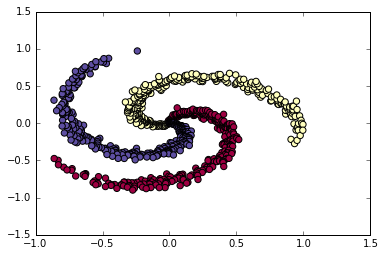

In [904]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

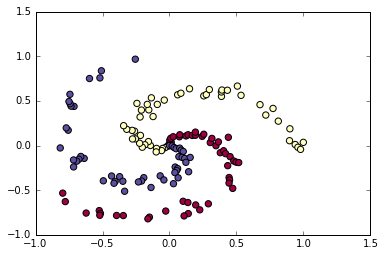

In [905]:
plt.scatter(Xtest[:, 0], Xtest[:, 1], c=ytest, s=40, cmap=plt.cm.Spectral)

In [906]:
# TF placeholder for the input and target data (y_targ)
x = tf.placeholder(tf.float32, [None, 2])
y_targ = tf.placeholder(tf.float32, [None, K])

In [907]:
# Layer 1 - ReLU activation layer
num_neurons = 100
W = tf.Variable(tf.random_normal([2,num_neurons]))
b = tf.Variable(tf.random_normal([num_neurons]))
layer1 = tf.nn.relu(tf.matmul(x, W) + b)

In [908]:
# Layer 2 - Softmax to generate class probabilities
W2 = tf.Variable(tf.random_normal([num_neurons,K]))
b2 = tf.Variable(tf.random_normal([K]))
y_output = tf.nn.softmax(tf.matmul(layer1, W2) + b2) # probability of being the correct class

In [909]:
# Numpy evaluations

In [910]:
# Loss function construction:
l = 0.001
reg_loss = 0.5 * l * (tf.reduce_sum(W*W) + tf.reduce_sum(W2*W2)) 
xentropy = tf.reduce_mean(-tf.reduce_sum( y_targ * tf.log(y_output), reduction_indices=[1] ))
loss = xentropy + reg_loss

In [911]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

In [912]:
init = tf.initialize_all_variables()

In [913]:
sess = tf.Session()

In [914]:
sess.run(init)

In [915]:
def next_batch(xs, ys, batch_size):
    xs_shape = np.shape(xs)
    ys_shape = np.shape(ys)
    idxs = rnd.sample(range(0,xs_shape[0]), batch_size)
    xs_rand = xs[idxs, :]
    ys_rand = ys[idxs,:]
    return xs_rand, ys_rand

In [916]:
for i in range(2000):
    batch_xs, batch_ys = next_batch(X, y_onehot, 50)
    sess.run(train_step, feed_dict={x: batch_xs, y_targ: batch_ys})

In [917]:
correct_pred = tf.equal(tf.argmax(y_output,1), tf.argmax(y_targ,1))
acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [918]:
print(sess.run(acc, feed_dict={x: Xtest, y_targ: y_onehot_test}))

0.96
